In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug  4 07:55:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Code Credit: Hugging Face**

**Dataset Credit: https://twitter.com/Dorialexander/status/1681671177696161794 **

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Finetune Llama-2-7b on a Google colab

Welcome to this Google Colab notebook that shows how to fine-tune the recent Llama-2-7b model on a single Google colab and turn it into a chatbot

We will leverage PEFT library from Hugging Face ecosystem, as well as QLoRA for more memory efficient finetuning

## Setup

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install `einops` as it is a requirement to load Falcon models.

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Loading the model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "TinyPixel/Llama-2-7B-bf16-sharded"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

Let's also load the tokenizer below

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # model_name = "TinyPixel/Llama-2-7B-bf16-sharded" 토크나이저는 기본 padding_side='left'인 토크나이저??
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
import transformers

transformers.__version__

'4.31.0'

- 다른 임포트

In [ ]:
# !pip install -q sentencepiece

In [ ]:
# from transformers import LlamaTokenizer, LlamaForCausalLM

# model_name = "meta-llama/Llama-2-7b-hf"    # I've also tried vanilla "meta-llama/Llama-2-70b-hf"
# tokenizer = LlamaTokenizer.from_pretrained(model_name)
# tokenizer.pad_token_id = tokenizer.eos_token_id    # for open-ended generation

# model = LlamaForCausalLM.from_pretrained(
#     model_name,
#     torch_dtype=torch.float16,
#     load_in_4bit=True,    # changing this to load_in_8bit=True works on smaller models
#     trust_remote_code=True,
#     device_map="auto",    # finds GPU
# )

## Dataset



In [ ]:
!pip install -q datasets

In [ ]:
# My Dataset

In [ ]:
# raw dataset split
folder_path = '/content/drive/MyDrive/llama2/'
path = 'utils/song_data_raw_20180921_ver02.csv'

train_data = pd.read_csv(folder_path + path)
train_data = train_data.drop(columns='Unnamed: 0')
train_data
#print(train_data.head(5))

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics
0,태지 보이스,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,269,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제...
1,시대유감(時代遺憾),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,타이틀 곡,"3,274",서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,왜 기다려 왔잖아\r\r\n모든 삶을 포기하는 소리를\r\r\n이 세상이 모두 미쳐...
2,수시아(誰是我),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,487,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,이 세상 그 누구도 나를 닮을 순 없네\r\r\n날 세상에 알릴 거야\r\r\n나 ...
3,이 밤이 깊어 가지만 (Remix),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,704,양현석\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,옛 생각에 까페 문을열고\r\r\n지난 추억을 기억하려했지\r\r\n부드러운 음악소...
4,Free Style,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,602,서태지\r\r\n작사\r\r\n김종서\r\r\n작사\r\r\n서태지\r\r\n작곡\...,항상 난 지나치기만 했네\r\r\n이젠 난 미련없이 끝내\r\r\n됐어 찾아냈어 난...
...,...,...,...,...,...,...,...,...,...
18165,덩크슛 (Dunk Shot),엔시티 드림,The First - The 1st Single Album,2017.02.09,Rock,인기 곡,"16,431",김광진\r\r\n작사\r\r\n김광진\r\r\n작곡\r\r\nkenzie\r\r\n편곡,주문을 외워보자\r\r\n유난히 고요하던\r\r\n밤 하늘을 바라보다가\r\r\n유...
18166,Chewing Gum,엔시티 드림,The First - The 1st Single Album,2017.02.09,Dance,NaN,"7,766",조윤경\r\r\n작사\r\r\n문설리\r\r\n작사\r\r\n정민지\r\r\n작사\...,C-c-c-c-c-c-Chewing Gum\r\r\nC-c-c-c-c-c C-c-c...
18167,Chewing Gum (泡泡糖),엔시티 드림,The First - The 1st Single Album,2017.02.09,Dance,NaN,"5,480",조윤경\r\r\n작사\r\r\n문설리\r\r\n작사\r\r\n정민지\r\r\n작사\...,C-c-c-c-c-c-Chewing Gum\r\r\nC-c-c-c-c-c C-c-c...
18168,Chewing Gum,엔시티 드림,Chewing Gum,2016.08.27,Dance,타이틀 곡,"25,546",조윤경\r\r\n작사\r\r\n문설리\r\r\n작사\r\r\n정민지\r\r\n작사\...,C-c-c-c-c-c-Chewing Gum\r\r\nC-c-c-c-c-c C-c-c...


In [ ]:
train, valid, test = train_data[:int(len(train_data)*0.7)], train_data[int(len(train_data)*0.7):int(len(train_data)*0.9)], train_data[int(len(train_data)*0.9):]
print(len(train))
print(len(valid))
print(len(test))

train

12719
3634
1817


,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics
0,태지 보이스,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,269,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제...
1,시대유감(時代遺憾),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,타이틀 곡,"3,274",서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,왜 기다려 왔잖아\r\r\n모든 삶을 포기하는 소리를\r\r\n이 세상이 모두 미쳐...
2,수시아(誰是我),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,487,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,이 세상 그 누구도 나를 닮을 순 없네\r\r\n날 세상에 알릴 거야\r\r\n나 ...
3,이 밤이 깊어 가지만 (Remix),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,704,양현석\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,옛 생각에 까페 문을열고\r\r\n지난 추억을 기억하려했지\r\r\n부드러운 음악소...
4,Free Style,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,602,서태지\r\r\n작사\r\r\n김종서\r\r\n작사\r\r\n서태지\r\r\n작곡\...,항상 난 지나치기만 했네\r\r\n이젠 난 미련없이 끝내\r\r\n됐어 찾아냈어 난...
...,...,...,...,...,...,...,...,...,...
12714,빠삐용 (Pop Beyond) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,N-Sonic We Make It Pop Beyond\r\r\nN-Sonic Boo...
12715,미치겠네 (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...
12716,미치겠네 (Acoustic Ver.) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,24,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...
12717,미치겠네,엔소닉,미치겠네,2014.05.29,Dance,타이틀 곡,435,원펀치\r\r\n작사\r\r\n원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...


In [ ]:
# train.to_csv(folder_path + 'utils/train.csv', index=False, encoding='utf-8', header=True)
# valid.to_csv(folder_path + 'utils/valid.csv', index=False, encoding='utf-8', header=True)
# test.to_csv(folder_path + 'utils/test.csv', index=False, encoding='utf-8', header=True)

In [ ]:
train.columns

Index(['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics'],
      dtype='object')

In [ ]:
dataset_pandas = pd.read_csv(folder_path + 'utils/train.csv', names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics']) # pandas
dataset_pandas

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics
0,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics
1,태지 보이스,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,269,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제...
2,시대유감(時代遺憾),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,타이틀 곡,"3,274",서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,왜 기다려 왔잖아\r\r\n모든 삶을 포기하는 소리를\r\r\n이 세상이 모두 미쳐...
3,수시아(誰是我),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,487,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,이 세상 그 누구도 나를 닮을 순 없네\r\r\n날 세상에 알릴 거야\r\r\n나 ...
4,이 밤이 깊어 가지만 (Remix),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,704,양현석\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,옛 생각에 까페 문을열고\r\r\n지난 추억을 기억하려했지\r\r\n부드러운 음악소...
...,...,...,...,...,...,...,...,...,...
12715,빠삐용 (Pop Beyond) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,N-Sonic We Make It Pop Beyond\r\r\nN-Sonic Boo...
12716,미치겠네 (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...
12717,미치겠네 (Acoustic Ver.) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,24,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...
12718,미치겠네,엔소닉,미치겠네,2014.05.29,Dance,타이틀 곡,435,원펀치\r\r\n작사\r\r\n원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...


In [ ]:
title_list = dataset_pandas['title'].tolist()
title_list

In [ ]:
lyrics_list = dataset_pandas['lyrics'].tolist()
lyrics_list

In [ ]:
dataset_pandas = pd.read_csv(folder_path + 'utils/train.csv', names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics']) # pandas
dataset_pandas

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics
0,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics
1,태지 보이스,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,269,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제...
2,시대유감(時代遺憾),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,타이틀 곡,"3,274",서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,왜 기다려 왔잖아\r\r\n모든 삶을 포기하는 소리를\r\r\n이 세상이 모두 미쳐...
3,수시아(誰是我),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,487,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,이 세상 그 누구도 나를 닮을 순 없네\r\r\n날 세상에 알릴 거야\r\r\n나 ...
4,이 밤이 깊어 가지만 (Remix),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,704,양현석\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,옛 생각에 까페 문을열고\r\r\n지난 추억을 기억하려했지\r\r\n부드러운 음악소...
...,...,...,...,...,...,...,...,...,...
12715,빠삐용 (Pop Beyond) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,N-Sonic We Make It Pop Beyond\r\r\nN-Sonic Boo...
12716,미치겠네 (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...
12717,미치겠네 (Acoustic Ver.) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,24,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...
12718,미치겠네,엔소닉,미치겠네,2014.05.29,Dance,타이틀 곡,435,원펀치\r\r\n작사\r\r\n원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

class LyricsDataset(Dataset):
    def tokenize(self, prompt, add_eos_token=True):
        ###CUTOFF_LEN = 1024
        CUTOFF_LEN = 512

        result = self.tokenizer(
            prompt,
            truncation=True,
            max_length=CUTOFF_LEN,
            padding='max_length',
            return_tensors=None, # 'pt' or None
        )
        if (
            result["input_ids"][-1] != self.tokenizer.eos_token_id
            and len(result["input_ids"]) < CUTOFF_LEN
            and add_eos_token
        ):
            result["input_ids"].append(self.tokenizer.eos_token_id)
            result["attention_mask"].append(1)

        result["labels"] = result["input_ids"].copy() # 정답 prompt 자체가 labels이 되어 들어감

        return result

    def __init__(self, data_path, mode="train", transform_func=None, tokenizer=None):
        if '_selected' in data_path:
          self.dataset = pd.read_csv(data_path, names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics', 'title_tokens_num', 'lyrics_tokens_num', 'sum_tokens_num']) # pandas
        else:
            self.dataset = pd.read_csv(data_path, names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
          'like', 'creator', 'lyrics']) # pandas

        self.dataset = self.dataset[1:]

        self.mode = mode
        self.transform_func = transform_func

        if mode == "train":
          self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side='right') # 학습 시에는 padding left
          self.tokenizer.pad_token = tokenizer.eos_token
        else:
          self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side='left') # 추론 시에는 padding left
          self.tokenizer.pad_token = tokenizer.eos_token

        self.title_list = self.dataset['title'].tolist() # KeyError 해결 위함
        self.lyrics_list = self.dataset['lyrics'].tolist() # KeyError 해결 위함

    def __len__(self):
        ###print(len(self.dataset))
        return len(self.dataset)

    def __getitem__(self, idx):
        # if index < 0 or index >= len(self.dataset):
        #     raise IndexError("Index out of range")

        title = self.title_list[idx] # string
        lyric = self.lyrics_list[idx] # string

        if self.mode == "train":
            basic_datasetdict =  {
                                    'title': title,
                                    'lyric': lyric,
                                }
        else: # "valid/eval"
            basic_datasetdict =  {
                                    'title': title,
                                }

        if self.transform_func != None: # map 함수 대신 구현
            transformed_datasetdict = self.transform_func(basic_datasetdict)
            for (key, value) in transformed_datasetdict.items():
                # print(key, type(key))
                # print(value, type(value))
                basic_datasetdict[key] = value

                test = self.tokenize(value)
                #print(type(test))
                #print(test['input_ids'])
                basic_datasetdict['input_ids'] = test['input_ids']
                basic_datasetdict['attention_mask'] = test['attention_mask']

            return basic_datasetdict

        else:
            return basic_datasetdict

In [ ]:
'''커스텀 데이터셋 로드'''
import random
from datasets import DatasetDict

# 프롬프트
prompt_format1 = "노래 제목에 따라 가사를 창의적으로 작성해주세요. ###제목: %s ###가사: %s"
prompt_format2 = "노래 제목이 주어지면 창의적으로 작사해주세요. 제목: %s 가사: %s"
prompt_format3 = "당신은 노래 가사를 작사하는 생성 모델입니다. 주어진 제목이 따라 가사를 생성해주세요. 제목: %s 가사: %s"

prompts = [prompt_format1, prompt_format2, prompt_format3]
def gen_prompt(song_data):
    selected_prompt_format = prompts[random.randint(0, len(prompts)-1)]
    ###print(song_data['title'])
    ###print(song_data['lyric'])
    return DatasetDict({'input_with_instruction': selected_prompt_format%(song_data['title'], str(song_data['lyric']).replace("\r", "").replace("\n", " "))})


def gen_prompt_for_inference(song_data):
    selected_prompt_format = prompts[random.randint(0, len(prompts)-1)]
    ###print(song_data['title'])
    return DatasetDict({'input_with_instruction': selected_prompt_format%(song_data['title'])})

# train/valid/test 데이터셋 spilt
# 7: 2: 1
folder_path = '/content/drive/MyDrive/llama2/'
# train_data = LyricsDataset(folder_path + 'utils/train.csv', mode="train", transform_func=gen_prompt, tokenizer=tokenizer)
# valid_data = LyricsDataset(folder_path + 'utils/valid.csv', mode="train", transform_func=gen_prompt, tokenizer=tokenizer)
# test_data = LyricsDataset(folder_path + 'utils/test.csv', mode="train", transform_func=gen_prompt, tokenizer=tokenizer)

##file_path = 'utils/train_selected.csv'
train_data = LyricsDataset(folder_path + 'utils/train_selected.csv', mode="train", transform_func=gen_prompt, tokenizer=tokenizer)
valid_data = LyricsDataset(folder_path + 'utils/valid_selected.csv', mode="train", transform_func=gen_prompt, tokenizer=tokenizer)

In [ ]:
len(train_data)

283

In [ ]:
train_data[100]['input_with_instruction']

'당신은 노래 가사를 작사하는 생성 모델입니다. 주어진 제목이 따라 가사를 생성해주세요. 제목: Hold On 가사: Hold On sung by Jet  You tried so hard to be someone That forgot who you are  You tried to fill some emptiness Till all you had spilled over  Now everything’s so far away That you don’t know where are You are  (Chorus) When all that you wanted When all that you had don’t seem so much For you to hold onto For you to hold onto  For you to belong to   When it’s hard to be yourself It’s not to be someone else  Still everything’s so far away That you forget where you are You are  (Chorus) When all that you wanted When all that you had don’t seem so much For you to hold onto For you to hold onto  Hold on Hold on Hold on Hold on  Hold on Hold on Hold on Hold on  (Chorus) When all that you wanted When all that you had don’t seem so much For you to hold onto For you to hold onto For you to hold onto  For you to belong to'

In [ ]:
train_data[200]['input_with_instruction']

"노래 제목이 주어지면 창의적으로 작사해주세요. 제목: BIG TRANSFORMER 가사: Yeah it's been a long time man The saga begins Come on let's do it BIG TRANSFORMER BIG TRANSFORMER FORMER 내 유치찬란했던 과거는 버리고 마냥 미소만 짓던 그런 소년 말고 난 다시 태어났어 A better man 크게 소리질러 봐 Say my name 예전에 기억하던 내 모습 이제 더는 찾아볼 수도 없을 걸 BIG TRANSFORMER FORMER BIG TRANSFORMER FORMER 별보다 밝게 빛나고 태양보다 뜨겁게 끝을 알 수가 없는 우주보다 드넓게 BIG TRANSFORMER FORMER"

In [ ]:
train_data[-1]['input_with_instruction']

'노래 제목에 따라 가사를 창의적으로 작성해주세요. 제목: Seven Springs Of Apink 가사: Believe wonders seven wonders  seven colors Seven seasons destiny same place Same dream same time always Meant to be time can only tell the passion within us A new day And a new start  A Pink'

In [ ]:
train_data[0]

{'title': 'Alone',
 'lyric': "정말로 자신있었어\r\r\n내가 원할 땐 언제나\r\r\n내게 달려온 너였으니\r\r\n한번도 신경 안 썼어\r\r\n누가 니곁에 있어도\r\r\n항상 내 주윌 맴돌던 너니까\r\r\n내 속에 니가 없었던\r\r\n그 많은 시간들이\r\r\n널 그렇게 떠나게 했어\r\r\n너무 갑자기 두려워져\r\r\n한순간 나 아닌 곳을\r\r\n바라본 너의 시선이\r\r\n그 동안 얼마나 너\r\r\n혼자서 아파한거니\r\r\n용서해줘 외롭던 시간만큼\r\r\n나 이제서야 알았어 난 느꼈어\r\r\nBabe you're the only for me\r\r\n니가 없는 하루는 길었지\r\r\n너 떠난 후 이제야 알았지\r\r\n매일같이 all day\r\r\n그렇게 넌 내 주위만\r\r\nall day oh my babe\r\r\n이제는 내게로 돌아와줘\r\r\nI really really miss\r\r\nyou don't say goodbye\r\r\n참 오랜 시간이었어\r\r\n늘 혼자 있게 했지\r\r\n널 그렇게 날 잊게 했어\r\r\n이젠 너 없인 힘들거야\r\r\n앞으로 내가 많이 널\r\r\n귀찮게 할지도 몰라\r\r\n이런맘 알 수 있니\r\r\n어쩔수 없는 거잖아\r\r\n이해해줘 예전에 사랑만큼\r\r\n너무나 두려워져\r\r\n한순간 나 아닌 곳을\r\r\n바라본 너의 시선이\r\r\n그 동안 얼마나 너\r\r\n혼자서 아파한거니",
 'input_with_instruction': "노래 제목에 따라 가사를 창의적으로 작성해주세요. 제목: Alone 가사: 정말로 자신있었어 내가 원할 땐 언제나 내게 달려온 너였으니 한번도 신경 안 썼어 누가 니곁에 있어도 항상 내 주윌 맴돌던 너니까 내 속에 니가 없었던 그 많은 시간들이 널 그렇게 떠나게 했어 너무 갑자기 두려워져 한순간 나 아닌 곳을 바라본 너의 시선이 그 동안 얼마나 너 혼자서 아파한거니 용서해줘 외롭던 시간만큼 나 이제서야 알았어 난 느꼈어 

In [ ]:
# 프롬프트
prompt_format1 = "노래 제목에 따라 가사를 창의적으로 작성해주세요. 제목: %s 가사: "
prompt_format2 = "노래 제목이 주어지면 창의적으로 작사해주세요. 제목: %s 가사: "
prompt_format3 = "당신은 노래 가사를 작사하는 생성 모델입니다. 주어진 제목이 따라 가사를 생성해주세요. 제목: %s 가사: " # 뒤를 생성해야 함

prompts = [prompt_format1, prompt_format2, prompt_format3]

def gen_prompt_for_inference(song_data):
    selected_prompt_format = prompts[random.randint(0, len(prompts)-1)]
    ###print(song_data['title'])
    return DatasetDict({'input_with_instruction': selected_prompt_format%(song_data['title'])})

test_data = LyricsDataset(folder_path + 'utils/test_selected.csv', mode="eval", transform_func=gen_prompt_for_inference, tokenizer=tokenizer) # 프롬프트 생성 방식 달라짐

In [ ]:
test_data[0]

{'title': 'Never Ending',
 'input_with_instruction': '노래 제목이 주어지면 창의적으로 작사해주세요. 제목: Never Ending 가사: ',
 'input_ids': [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2

In [ ]:
train_data[0]['input_with_instruction']

'노래 제목에 따라 가사를 창의적으로 작성해주세요. 제목: 태지 보이스 가사: 갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제나 식지않는 마음이 있어\r\r\n자유로운 내뜻을 막을순 없어\r\r\nTaiji Boys 언제나 영원히\r\r\nTaiji Boys 더 넓은 세상이\r\r\nTaiji Boys 우리의 마음이\r\r\nTaiji Boys 하나가 돼\r\r\n\r\r\n무심코 던진 돌에 개구리는 죽어\r\r\n우리가 사는 이유를 알고 싶었어\r\r\nTaiji Boys 언제나 영원히\r\r\nTaiji Boys 더 넓은 세상이\r\r\nTaiji Boys 우리의 마음이\r\r\nTaiji Boys 하나가 돼'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side='right') # 학습 시에는 padding left
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
###CUTOFF_LEN = 1024
CUTOFF_LEN = 512

result = tokenizer(
    train_data[0]['input_with_instruction'],
    truncation=True,
    max_length=CUTOFF_LEN,
    padding='max_length',
    return_tensors='pt',
)

In [ ]:
result

{'input_ids': tensor([[    1, 29871,   238,  ...,     2,     2,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
len(result['input_ids'])

1

In [ ]:
result['input_ids'].size()

torch.Size([1, 1024])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side='left') # 추론 시에는 padding left
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
CUTOFF_LEN = 1024

result = tokenizer(
    train_data[0]['input_with_instruction'],
    truncation=True,
    max_length=CUTOFF_LEN,
    padding='max_length',
    return_tensors=None,
)

In [ ]:
result

{'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [ ]:
len(result['input_ids'])

1024

In [ ]:
result = tokenizer(
    train_data[0]['input_with_instruction'],
    truncation=True,
    max_length=CUTOFF_LEN,
    padding=True, # right
    return_tensors=None,
)

In [ ]:
dataset_pandas['title'][1]

'태지 보이스'

In [ ]:
dataset_pandas['lyrics'][1]

'갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제나 식지않는 마음이 있어\r\r\n자유로운 내뜻을 막을순 없어\r\r\nTaiji Boys 언제나 영원히\r\r\nTaiji Boys 더 넓은 세상이\r\r\nTaiji Boys 우리의 마음이\r\r\nTaiji Boys 하나가 돼\r\r\n\r\r\n무심코 던진 돌에 개구리는 죽어\r\r\n우리가 사는 이유를 알고 싶었어\r\r\nTaiji Boys 언제나 영원히\r\r\nTaiji Boys 더 넓은 세상이\r\r\nTaiji Boys 우리의 마음이\r\r\nTaiji Boys 하나가 돼'

In [ ]:
# raw data의 최대 길이 구하기

dataset_pandas['title'].apply(len)

0         5
1         6
2        10
3         8
4        19
         ..
12715    24
12716    12
12717    28
12718     4
12719     8
Name: title, Length: 12720, dtype: int64

In [ ]:
tokenizer(
            dataset_pandas['title'][1],
            padding=False,
            return_tensors=None,
        )

{'input_ids': [1, 29871, 240, 134, 159, 30811, 29871, 31199, 30393, 30784], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer(
            dataset_pandas['lyrics'][1],
            padding=False,
            return_tensors=None,
        )

{'input_ids': [1, 29871, 237, 179, 139, 30970, 29871, 239, 154, 137, 31081, 29871, 237, 182, 182, 30393, 238, 161, 131, 29871, 31327, 30826, 31054, 237, 181, 147, 29871, 239, 154, 137, 31129, 30004, 30004, 13, 31199, 30393, 31081, 29871, 237, 187, 187, 238, 179, 153, 31054, 31136, 29871, 31578, 31158, 31354, 29871, 239, 161, 139, 31129, 30004, 30004, 13, 239, 153, 187, 31306, 31207, 29871, 31895, 30811, 239, 152, 141, 31081, 29871, 31417, 31966, 30393, 29871, 239, 161, 139, 31129, 30004, 30004, 13, 31013, 31533, 30906, 239, 157, 183, 29871, 31940, 238, 159, 190, 31286, 29871, 238, 170, 140, 31286, 239, 139, 159, 29871, 239, 154, 137, 31129, 30004, 30004, 13, 29911, 29874, 13188, 22148, 29871, 239, 153, 187, 31306, 31207, 29871, 31288, 31198, 240, 161, 139, 30004, 30004, 13, 29911, 29874, 13188, 22148, 29871, 238, 144, 151, 29871, 238, 135, 150, 31354, 29871, 31578, 31158, 30393, 30004, 30004, 13, 29911, 29874, 13188, 22148, 29871, 31327, 30826, 30708, 29871, 31417, 31966, 30393, 30004,

In [ ]:
def cal_tokens_num(x):
  res = tokenizer(
              x,
              padding=False,
              return_tensors=None,
          )

  return len(res['input_ids'])

In [ ]:
dataset_pandas['title_tokens_num'] = dataset_pandas['title'].apply(lambda x: cal_tokens_num(x))

dataset_pandas

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,title_tokens_num
0,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,2
1,태지 보이스,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,269,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제...,10
2,시대유감(時代遺憾),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,타이틀 곡,"3,274",서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,왜 기다려 왔잖아\r\r\n모든 삶을 포기하는 소리를\r\r\n이 세상이 모두 미쳐...,18
3,수시아(誰是我),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,487,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,이 세상 그 누구도 나를 닮을 순 없네\r\r\n날 세상에 알릴 거야\r\r\n나 ...,12
4,이 밤이 깊어 가지만 (Remix),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,704,양현석\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,옛 생각에 까페 문을열고\r\r\n지난 추억을 기억하려했지\r\r\n부드러운 음악소...,21
...,...,...,...,...,...,...,...,...,...,...
12715,빠삐용 (Pop Beyond) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,N-Sonic We Make It Pop Beyond\r\r\nN-Sonic Boo...,17
12716,미치겠네 (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...,15
12717,미치겠네 (Acoustic Ver.) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,24,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...,21
12718,미치겠네,엔소닉,미치겠네,2014.05.29,Dance,타이틀 곡,435,원펀치\r\r\n작사\r\r\n원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...,12


In [ ]:
dataset_pandas['lyrics_tokens_num'] = dataset_pandas['lyrics'].apply(lambda x: cal_tokens_num(str(x)))

dataset_pandas

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,title_tokens_num,lyrics_tokens_num
0,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,2,3
1,태지 보이스,서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,269,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,갈수 없는 곳이란 우리에겐 없어\r\r\n보이는 길밖에도 세상은 있어\r\r\n언제...,10,304
2,시대유감(時代遺憾),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,타이틀 곡,"3,274",서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,왜 기다려 왔잖아\r\r\n모든 삶을 포기하는 소리를\r\r\n이 세상이 모두 미쳐...,18,980
3,수시아(誰是我),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,487,서태지\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,이 세상 그 누구도 나를 닮을 순 없네\r\r\n날 세상에 알릴 거야\r\r\n나 ...,12,254
4,이 밤이 깊어 가지만 (Remix),서태지와 아이들,시대유감(時代遺憾),1996.06.07,Rock,NaN,704,양현석\r\r\n작사\r\r\n서태지\r\r\n작곡\r\r\n서태지\r\r\n편곡,옛 생각에 까페 문을열고\r\r\n지난 추억을 기억하려했지\r\r\n부드러운 음악소...,21,792
...,...,...,...,...,...,...,...,...,...,...,...
12715,빠삐용 (Pop Beyond) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,N-Sonic We Make It Pop Beyond\r\r\nN-Sonic Boo...,17,1309
12716,미치겠네 (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,21,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...,15,1298
12717,미치겠네 (Acoustic Ver.) (Inst.),엔소닉,Reset,2014.06.09,Dance,NaN,24,원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...,21,1298
12718,미치겠네,엔소닉,미치겠네,2014.05.29,Dance,타이틀 곡,435,원펀치\r\r\n작사\r\r\n원펀치\r\r\n작곡\r\r\n원펀치\r\r\n편곡,오늘 아침 문자를 주고받는데\r\r\n안부리던 애교 작렬이던 너 Oh\r\r\n좀 ...,12,1298


In [ ]:
dataset_pandas['sum_tokens_num'] = dataset_pandas['title_tokens_num'] + dataset_pandas['lyrics_tokens_num']

In [ ]:
max(dataset_pandas['sum_tokens_num'])

5562

In [ ]:
max_value = dataset_pandas['sum_tokens_num'].max()
max_rows = dataset_pandas[dataset_pandas['sum_tokens_num'] == max_value]

max_rows

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,title_tokens_num,lyrics_tokens_num,sum_tokens_num
2428,Mega,엔알지,NRG (New Radiancy Group),1997.11,Dance,NaN,62,NaN,불안해 넌 말을해\r\r\n니네 무슨 불만이 많은데\r\r\n줏대 없는 애들이\r\...,3,5559,5562


In [ ]:
s = max_rows['lyrics'].str.replace('\\r\\n', '\n', regex=True).iloc[0]
print(s)

불안해 넌 말을해
니네 무슨 불만이 많은데
줏대 없는 애들이
공부를 못한대
그리해 꼭꼭꼭 투덜대
대학 쑥쑥쑥 붙은 형이 말을해
이 세상에서
공부가 제일 쉬웠다는데
열심히 공부해
난나 열심히 해
난나 이제 알아
난나 이제 공부 잘해
공부 잘하고 잘노는 애가
요즘 시대엔 짱이라고 말하지
겉모습만 멀쩡한것보단
똑똑한 애가 연애도 잘한대
누가 뭐라 할말 있겠어
흠잡을 데 없이 완벽한걸
나또한 그렇게 살수 있다면
야야 정말 멋지구나
남얘기가 아냐 외면하지마
도전해 볼만해
미리 포긴 왜해
뜻이 있는 곳에 길이 있는 법
나의 꿈을 이룰수 있어
나에게 기횐 한번 뿐이야
자신있게 살아가는 거야
내가 만들거야
나의 멋진 미래를
불안해 넌 말을해
니네 무슨 불만이 많은데
줏대 없는 애들이
공부를 못한대
그리해 꼭꼭꼭 투덜대
대학 쑥쑥쑥 붙은 형이 말을해
이 세상에서
공부가 제일 쉬웠다는데
열심히 공부해
난나 열심히 해
난나 이제 알아
난나 이제 공부 잘해
너는 가끔 내게 물었지
감춰온 사랑이 궁금하다고
하지만 내맘 비밀이라 말했어
오 다름아닌 너였어
너의 하나뿐인 사랑은
내게도 소중한 친구인데
내가 어떻게
너라 말할수 있겠어
나를 보는 가슴엔 항상
내 친구의 사랑이 있던
그런 슬픔도 익숙한 나인데
너만 좋다면
나의 사랑을 모른채
언제나 친구와 행복한 널 보면
그만큼 내안에 서러움도
녹아 내렸어
내가 해줄수 없어도
넌 그저 행복한 미솔 지켜줘
영원히 너를 향한
나의 사랑은 그 모습으로 족해
후후 왈칵 왈칵 나의 눈물
후후 왈칵 왈칵 흘러도
후후 감춰 감춰 나의 사랑
후후 감춰감춰 널위해 지켜
미친듯 달리는 새벽의
굉음속에 열일곱 미랠
아낌없이 걸고
더 이상 여기서
나빠질게 있냐며
어둠의 고통속으로 빠져들어
단 하루를 살아도
자유롭고 싶다는
그들의 외침 끝내 외면한채
덧없는 절망에 지친
어린 영혼을 우리는 심판하지
나도 그런 때가 있었다며
같지 않을 용서와 때묻은
위선 눈물 그속에서
더욱 멍든 아이들 워
욕하지마 그들의 분놀
우리 책임 져야만해
영혼까지 상처를 받은
열일곱의 절규를


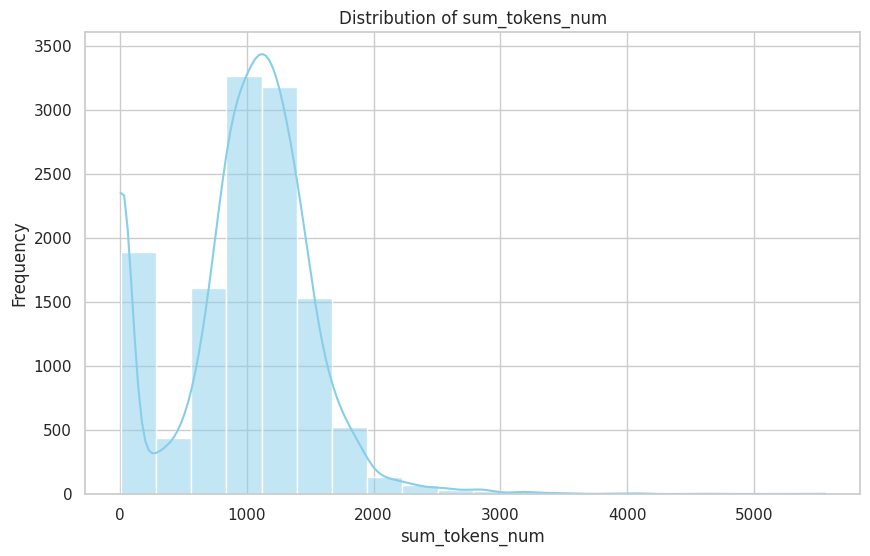

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 예시 데이터프레임과 열 이름으로 가정하겠습니다.
# dataset_pandas = ...  # 예시 데이터프레임
# 'sum_tokens_num' 열이 정의되어 있다고 가정합니다.

# seaborn 스타일 설정
sns.set(style='whitegrid')

# 히스토그램을 그리기 위해 seaborn을 사용합니다.
plt.figure(figsize=(10, 6))  # 그래프 크기 조정
sns.histplot(data=dataset_pandas, x='sum_tokens_num', bins=20, kde=True, color='skyblue')
plt.title('Distribution of sum_tokens_num')
plt.xlabel('sum_tokens_num')
plt.ylabel('Frequency')
plt.show()


In [ ]:
res = tokenizer(
            prompt_format3,
            padding=False,
            return_tensors=None,
        )

len(res['input_ids'])

84

In [ ]:
### 1024 - 84 = 940
### 512 - 84 = 428
# RAW DATA에서 'title' 토큰 수와 'lyrics' 토큰 수가 940 개 이하인 데이터만 다시 저장

# train.csv 정제
dataset_pandas = pd.read_csv(folder_path + 'utils/train.csv', names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics']) # pandas

dataset_pandas = dataset_pandas[1:]
print('정제 전 데이터 행 개수: ', len(dataset_pandas))

dataset_pandas = dataset_pandas.dropna(subset=['title', 'lyrics'])

dataset_pandas['title_tokens_num'] = dataset_pandas['title'].apply(lambda x: cal_tokens_num(x))
dataset_pandas['lyrics_tokens_num'] = dataset_pandas['lyrics'].apply(lambda x: cal_tokens_num(str(x)))
dataset_pandas['sum_tokens_num'] = dataset_pandas['title_tokens_num'] + dataset_pandas['lyrics_tokens_num']
print(max(dataset_pandas['sum_tokens_num']))
print(min(dataset_pandas['sum_tokens_num']))

###filtered_rows = dataset_pandas[dataset_pandas['sum_tokens_num'] <= 940]
filtered_rows = dataset_pandas[(dataset_pandas['sum_tokens_num'] <= 430) & (100 <= dataset_pandas['sum_tokens_num'])]
filtered_rows.to_csv(folder_path + 'utils/train_selected.csv', index=False, encoding='utf-8', header=True)
print('정제 후 데이터 행 개수: ', len(filtered_rows))

정제 전 데이터 행 개수:  12719
4634
24
정제 후 데이터 행 개수:  283


In [ ]:
pd.set_option('display.max_colwidth', None)

dataset_pandas[dataset_pandas['sum_tokens_num'] <= 50]

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,title_tokens_num,lyrics_tokens_num,sum_tokens_num
2425,Intro,엔알지,NRG (New Radiancy Group),1997.11,Dance,NaN,31,NaN,race!\r\r\nrace!\r\r\n(ra)(ra)race!\r\r\n(ra)(ra)race!,3,28,31
14652,Interlude : 뭐해,방탄소년단,DARK&WILD,2014.08.20,Rap / Hip-hop,NaN,"37,535",Slow Rabbit\r\r\n작곡,뭐해\r\r\n\r\r\n뭐해\r\r\n\r\r\n\r\r\n\r\r\n뭐해,10,32,42
2414,Intro,엔알지,Race,1998,Dance,NaN,20,NaN,race!\r\r\nrace!\r\r\n(ra)(ra)race!\r\r\n(ra)(ra)race!,3,28,31
8373,Break It (Inst.),카라,Blooming,2007.03.29,Dance,NaN,409,한상원\r\r\n작곡,가사가 없는 연주곡 입니다.,6,23,29
13444,EXO Keep On Dancing,엑소,EXO PLANET #3 -The EXO`rDIUM(dot)- Live Album,2017.10.25,Dance,NaN,"13,593",심재원\r\r\n작사\r\r\n심재원\r\r\n작곡\r\r\n숀 (SHAUN)\r\r\n작곡\r\r\n심재원\r\r\n편곡\r\r\n숀 (SHAUN)\r\r\n편곡,EXO Keep On Dancing\r\r\nFour three two one\r\r\nEXO Keep On Dancing,7,24,31
1182,L`esprit D`escalier,제트,Shine On (Digital Album Version),2006.09.29,Rock,NaN,3,NaN,All you have to do\r\r\nAll you have to do\r\r\n\r\r\nAhhhhhhh Ahhhhh,10,27,37
11340,Season 2,인피니트,Be Back,2014.07.22,Dance,NaN,"15,687",NaN,난 너밖엔 안보인다,4,20,24
3017,기억나니?,신화,신화 9집 (White Edition),2008.07.03,Dance,NaN,"1,914",NaN,가사가 없는 멘트곡입니다.,9,24,33
2340,Intro,엔알지,Concert with Antonio,2001.10,Dance,NaN,17,NaN,race!\r\r\nrace!\r\r\n(ra)(ra)race!\r\r\n(ra)(ra)race!,3,28,31
3027,기억나니?,신화,신화 9집,2008.04.03,Dance,NaN,"1,613",NaN,가사가 없는 멘트곡입니다.,9,24,33


In [ ]:
dataset_pandas[dataset_pandas['sum_tokens_num'] <= 100]

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,title_tokens_num,lyrics_tokens_num,sum_tokens_num
13141,LE NOIR,비에이피,NOIR,2016.11.07,Dance,NaN,"4,230",방용국\r\r\n작사\r\r\n방용국\r\r\n작곡\r\r\n김창락\r\r\n작곡\r\r\n강기훈\r\r\n작곡\r\r\n지우\r\r\n작곡\r\r\n강기훈\r\r\n편곡\r\r\n지우\r\r\n편곡,Le Noir\r\r\nIf I never knew you\r\r\nIf I never knew the love\r\r\nI just wanna feel this moment\r\r\nLe Noir\r\r\nIf I never knew you\r\r\nIf I never knew the love\r\r\nI don't hate you like yesterday,4,65,69
2425,Intro,엔알지,NRG (New Radiancy Group),1997.11,Dance,NaN,31,NaN,race!\r\r\nrace!\r\r\n(ra)(ra)race!\r\r\n(ra)(ra)race!,3,28,31
11570,aRtisT,틴탑,aRtisT,2012.05.30,Dance,NaN,"3,219",별들의 전쟁\r\r\n작사\r\r\n용감한 형제\r\r\n작곡\r\r\n똘아이박\r\r\n작곡\r\r\n똘아이박\r\r\n편곡,I feel so empty\r\r\nit's like it's kinda\r\r\ndamn I can't explain\r\r\nplease save me from this pain\r\r\nI can't take this anymore\r\r\nbaby please\r\r\nplease don't drive me insane\r\r\nI miss you everyday,5,73,78
11552,No. 1,틴탑,No.1,2013.02.25,Dance,NaN,"4,111",용감한 형제\r\r\n작사\r\r\n마부스 (Maboos)\r\r\n작사\r\r\n용감한 형제\r\r\n작곡\r\r\n용감한 형제\r\r\n편곡,2013 Now's The Time\r\r\nT Double E N T O P\r\r\nFinally They Release\r\r\nTheir Full Album\r\r\nIt's Not A Mini\r\r\nIt's Not A Single\r\r\nIt's Full Album\r\r\nSo Check This Out\r\r\nNo 1,5,75,80
14652,Interlude : 뭐해,방탄소년단,DARK&WILD,2014.08.20,Rap / Hip-hop,NaN,"37,535",Slow Rabbit\r\r\n작곡,뭐해\r\r\n\r\r\n뭐해\r\r\n\r\r\n\r\r\n\r\r\n뭐해,10,32,42
3213,Intro,신화,First Mythology: 2001 1st Live Concert,2001.04.01,Dance,NaN,750,NaN,마지막 내 몸짓속에 그 누구도 참을 수 없어\r\r\n느껴봐 소리쳐봐 내 모든걸 보여주겠어\r\r\n오~~~오~~~~오~~~~~오~~~~~,3,93,96
1584,서곡 (Intro),알이에프,Rave Effect,1995.03,Dance,NaN,27,무\r\r\n작사\r\r\n이용민\r\r\n작곡\r\r\n이용민\r\r\n편곡,"Yo! R.ef is back 1996, coming\r\r\nstraight at you with the rave back\r\r\ngive you the wave yo!\r\r\nsay back to the black!!\r\r\nEverybody say back-\r\r\nComeon say back-\r\r\nYe!! R.ef is back to the black",10,77,87
12902,Time To Rock Da Show,BP 라니아,Time To Rock Da Show,2011.11.17,Dance,NaN,82,별들의 전쟁\r\r\n작사\r\r\n용감한 형제\r\r\n작곡\r\r\n별들의 전쟁\r\r\n작곡\r\r\n별들의 전쟁\r\r\n편곡,"Ladies and gentlemen\r\r\nIt's time to rock da show\r\r\nLet me introduce\r\r\nThe incredibly outstandin' artist\r\r\nLet's rock\r\r\nIt's time to rock da show, show\r\r\nEverybody on the floor, floor\r\r\nIt's time to rock da show show\r\r\nEverybody on the floor floor",6,84,90
4089,사랑이 전부였던 날,god,보통날,2004.12.08,Ballad,NaN,"1,429",권태은\r\r\n작곡\r\r\n권태은\r\r\n편곡,신스케 우리 이제 어디로 가는거야\r\r\n멀리\r\r\n너 정말 괜찮은 거지\r\r\n응,20,65,85
5112,Intro (Can`t You Feel),블랙 비트,Black Beat #2002 - The First Performance 001,2002.03.01,Ballad,NaN,19,NaN,It's love I know\r\r\n그대 그리며 기도해요\r\r\nCan't you feel my love\r\r\nIt's all for you\r\r\nBaby because of you\r\r\n그대 내곁에 잠이 들죠 forever,11,72,83


In [ ]:
# valid.csv 정제

dataset_pandas = pd.read_csv(folder_path + 'utils/valid.csv', names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics']) # pandas

dataset_pandas = dataset_pandas[1:]
print('정제 전 데이터 행 개수: ', len(dataset_pandas))

dataset_pandas = dataset_pandas.dropna(subset=['title', 'lyrics'])

dataset_pandas['title_tokens_num'] = dataset_pandas['title'].apply(lambda x: cal_tokens_num(x))
dataset_pandas['lyrics_tokens_num'] = dataset_pandas['lyrics'].apply(lambda x: cal_tokens_num(str(x)))
dataset_pandas['sum_tokens_num'] = dataset_pandas['title_tokens_num'] + dataset_pandas['lyrics_tokens_num']
print(max(dataset_pandas['sum_tokens_num']))
print(min(dataset_pandas['sum_tokens_num']))

###filtered_rows = dataset_pandas[dataset_pandas['sum_tokens_num'] <= 940]
filtered_rows = dataset_pandas[(dataset_pandas['sum_tokens_num'] <= 430) & (100 <= dataset_pandas['sum_tokens_num'])]
print('정제 후 데이터 행 개수: ', len(filtered_rows))

정제 전 데이터 행 개수:  3634
4682
16
정제 후 데이터 행 개수:  80


In [ ]:
# test.csv 정제

dataset_pandas = pd.read_csv(folder_path + 'utils/test.csv', names=['title', 'artist', 'album', 'release_date', 'song_genre', 'is_title',
       'like', 'creator', 'lyrics']) # pandas
dataset_pandas = dataset_pandas[1:]
print('정제 전 데이터 행 개수: ', len(dataset_pandas))

dataset_pandas = dataset_pandas.dropna(subset=['title', 'lyrics'])

dataset_pandas['title_tokens_num'] = dataset_pandas['title'].apply(lambda x: cal_tokens_num(x))
dataset_pandas['lyrics_tokens_num'] = dataset_pandas['lyrics'].apply(lambda x: cal_tokens_num(str(x)))
dataset_pandas['sum_tokens_num'] = dataset_pandas['title_tokens_num'] + dataset_pandas['lyrics_tokens_num']
print(max(dataset_pandas['sum_tokens_num']))
print(min(dataset_pandas['sum_tokens_num']))

###filtered_rows = dataset_pandas[dataset_pandas['sum_tokens_num'] <= 940]
filtered_rows = dataset_pandas[(dataset_pandas['sum_tokens_num'] <= 430) & (100 <= dataset_pandas['sum_tokens_num'])]
filtered_rows.to_csv(folder_path + 'utils/test_selected.csv', index=False, encoding='utf-8', header=True)
print('정제 후 데이터 행 개수: ', len(filtered_rows))

정제 전 데이터 행 개수:  1817
5562
12
정제 후 데이터 행 개수:  34


In [ ]:
filtered_rows

,title,artist,album,release_date,song_genre,is_title,like,creator,lyrics,title_tokens_num,lyrics_tokens_num,sum_tokens_num
6,TENSION UP!,업텐션,一級秘密 (일급비밀),2015.09.11,Dance,NaN,816,신혁\r\r\n작곡\r\r\nMrey\r\r\n작곡\r\r\n신혁\r\r\n편곡\r...,NaN,6,2,8
9,Never Ending,업텐션,一級秘密 (일급비밀),2015.09.11,Dance,NaN,"1,189",창조\r\r\n작사\r\r\n허성진\r\r\n작사\r\r\n허성진\r\r\n작곡\r...,은은하게 퍼진 향기\r\r\n너의 눈빛이 날 끌어당겨\r\r\n너에게 잠겨 헤어 나...,4,817,821
12,Dash,업텐션,불후의 명곡 - 전설을 노래하다 (백지영 편),2015.11.28,Ballad,Dash,199,이승호\r\r\n작사\r\r\n홍재선\r\r\n작곡\r\r\n정민경\r\r\n편곡\...,NaN,3,2,5
20,Winter Breeze,브이에이브이,Spotlight,2018.01.29,Ballad,NaN,115,초콜릿 노트\r\r\n작사\r\r\n유송연\r\r\n작곡\r\r\nGabby\r\r...,창문 사이로 바람이 불어와\r\r\n하얀 눈이 가득 쌓인 그 거리에\r\r\n추억 ...,5,648,653
22,She`s Mine (Inst.),브이에이브이,She`s Mine,2017.11.02,Dance,NaN,63,Coach & Sendo\r\r\n작곡\r\r\nCoach & Sendo\r\r\n편곡,NaN,8,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...
1803,JOY (Inst.),엔시티 드림,JOY - SM STATION,2017.12.15,Dance,NaN,"2,947",James Pierpont\r\r\n작곡\r\r\nGeorge Frideric Ha...,Jingle bells jingle bells jingle\r\r\nall the ...,7,816,823
1805,La La Love,엔시티 드림,We Young - The 1st Mini Album,2017.08.17,Dance,인기 곡,"14,016",신아녜스\r\r\n작사\r\r\n마크 (MARK)\r\r\n작사\r\r\nDavid...,Baby 스치는 바람을 따라\r\r\n떠날래 아무도 모르게\r\r\n하루 이틀 미뤘...,4,817,821
1808,We Young (Chinese Ver.),엔시티 드림,We Young - The 1st Mini Album,2017.08.17,Dance,NaN,"7,620",왕정운\r\r\n작사\r\r\nkenzie\r\r\n작곡\r\r\nLDN Noise...,We just wanna have fun\r\r\ncause' we hot and ...,8,791,799
1809,(Bonus Track) Trigger the fever,엔시티 드림,We Young - The 1st Mini Album,2017.08.17,Dance,NaN,"10,158",100%서정\r\r\n작사\r\r\n황지원 (Jam Factory)\r\r\n작사\...,저 드높은 하늘 끝에 난\r\r\n지구를 닮은 공 하나로\r\r\nGo Trigge...,12,835,847


In [ ]:
song_data =  {
              'title': dataset_pandas['title'][1],
              'lyric': dataset_pandas['lyrics'][1],
            }

print(song_data['title'])
print(song_data['lyric'])
result = DatasetDict({'input_with_instruction': prompt_format3%(song_data['title'], song_data['lyric'])})

result

In [ ]:
tokenizer(
            text,
            truncation=True,
            max_length=CUTOFF_LEN,
            padding=False,
            return_tensors=None,
        )

In [ ]:
title_list = dataset_pandas['title'].tolist()

title = title_list[1]
title

'Run & Run'

In [ ]:
title

In [ ]:
title_list[0]

'title'

In [ ]:
test_data[0]

title
lyrics


{'title': 'title',
 'lyric': 'lyrics',
 'input_with_instruction': '노래 제목이 주어지면 창의적으로 작사해주세요. 제목: title 가사: lyrics',
 'input_ids': [1,
  29871,
  238,
  136,
  187,
  238,
  161,
  155,
  29871,
  31306,
  238,
  173,
  172,
  30393,
  29871,
  30981,
  31129,
  30811,
  31747,
  29871,
  239,
  179,
  192,
  30708,
  239,
  163,
  132,
  239,
  159,
  191,
  30906,
  29871,
  239,
  161,
  148,
  30791,
  31435,
  30981,
  31578,
  31527,
  29889,
  29871,
  31306,
  238,
  173,
  172,
  29901,
  3611,
  29871,
  30903,
  30791,
  29901,
  26627,
  1199,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [ ]:
dataset = train_data

dataset

In [ ]:
# dataset[0]

In [ ]:
len(dataset)

283

In [ ]:
# dataset[12720-1]

In [ ]:
len(dataset_pandas)

11176

In [ ]:
from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

## Loading the trainer

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments

output_dir = "./results_2"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 5
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 50
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Then finally pass everthing to the trainer

In [ ]:
from trl import SFTTrainer

###max_seq_length = 1024
max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:119: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Train the model

Now let's train the model! Simply call `trainer.train()`

In [ ]:
len(dataset)

283

In [ ]:
# dataset[12719-1]

In [ ]:
# dataset[12719]

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,1.595200
20,1.470100
30,1.305600
40,1.318500
50,1.229100


TrainOutput(global_step=50, training_loss=1.3837078857421874, metrics={'train_runtime': 1262.1245, 'train_samples_per_second': 0.634, 'train_steps_per_second': 0.04, 'total_flos': 8342048247644160.0, 'train_loss': 1.3837078857421874, 'epoch': 2.82})

During training, the model should converge nicely as follows:

![image](https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/loss-falcon-7b.png)

The `SFTTrainer` also takes care of properly saving only the adapters during training instead of saving the entire model.

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained(folder_path + "outputs_2")

In [ ]:
model.save_pretrained(folder_path + "llama_finetuned_2")

NotImplementedError: ignored

In [ ]:
# 학습한 모델로 결과 추론
infer_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side='left') # 추론 시에는 padding left
infer_tokenizer.pad_token = infer_tokenizer.eos_token

In [ ]:
output_lora_config = LoraConfig.from_pretrained(folder_path + 'outputs_2')
output_model = get_peft_model(model, output_lora_config)

In [ ]:
# dataset['text']

In [ ]:
# text = "Écrire un texte dans un style baroque sur la glace et le feu ### Assistant: Si j'en luis éton"
# device = "cuda:0"

# inputs = infer_tokenizer(text, return_tensors="pt").to(device)
# outputs = output_model.generate(**inputs, max_new_tokens=50)
# print(infer_tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
test_data[0]

In [ ]:
test_data[0]['input_with_instruction']

In [ ]:
test_data[0]['input_ids']

In [ ]:
test_data[0]['attention_mask']

In [ ]:
text = "노래 제목이 주어지면 창의적으로 작사해주세요. 제목: Never Ending 가사: "
device = 'cuda' #"cuda:0"

inputs = infer_tokenizer(text, return_tensors=None)
inputs

{'input_ids': [1, 29871, 238, 136, 187, 238, 161, 155, 29871, 31306, 238, 173, 172, 30393, 29871, 30981, 31129, 30811, 31747, 29871, 239, 179, 192, 30708, 239, 163, 132, 239, 159, 191, 30906, 29871, 239, 161, 148, 30791, 31435, 30981, 31578, 31527, 29889, 29871, 31306, 238, 173, 172, 29901, 12391, 2796, 292, 29871, 30903, 30791, 29901, 29871], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
inputs = infer_tokenizer(text, return_tensors="pt").to(device)
outputs = output_model.generate(**inputs, max_new_tokens=128)
print(infer_tokenizer.decode(outputs[0], skip_special_tokens=True))

노래 제목이 주어지면 창의적으로 작사해주세요. 제목: Never Ending 가사: 너무 잘 알고 있어요 너무 잘 알고 있어요 너무 잘 알고 있어요 너무 잘 알고 있어요 너무 잘 알고 있어요 너무 잘 알고 있어요 너무 잘


In [ ]:
from huggingface_hub import login
login()

In [ ]:
# model.push_to_hub("llama2-qlora-finetunined-french")
model.push_to_hub("llama2-lyrics-finetunined-sample2")

NotImplementedError: ignored

In [ ]:
train_data[170]['title']

'배신'

In [ ]:
train_data[170]['lyric']

'너 없는 세상도 눈부신걸 알아\r\r\n더 이상은 너만을 바라보던\r\r\n내가 아니야\r\r\n그렇게 슬픈듯이 쳐다보지마\r\r\n이제 더는 너에게\r\r\n줄 수 있는 마음이 없어\r\r\n지금 남은건 떠나는 일 뿐이란걸\r\r\n고맙게도 떠나는 날\r\r\n잡지 않을 너잖아\r\r\n사랑했던 난 이젠 없어\r\r\n너를 너를 모두 잊었어\r\r\n후회해도 다신 나를 돌아보지마\r\r\n함께한 우리 기억 따윈\r\r\n이젠 없어 모두 버려줘\r\r\n돌아서면 그만인 이별까지\r\r\n아름다울 필욘 없잖아'

In [ ]:
train_data[170]['input_with_instruction']

'당신은 노래 가사를 작사하는 생성 모델입니다. 주어진 제목이 따라 가사를 생성해주세요. 제목: 배신 가사: 너 없는 세상도 눈부신걸 알아 더 이상은 너만을 바라보던 내가 아니야 그렇게 슬픈듯이 쳐다보지마 이제 더는 너에게 줄 수 있는 마음이 없어 지금 남은건 떠나는 일 뿐이란걸 고맙게도 떠나는 날 잡지 않을 너잖아 사랑했던 난 이젠 없어 너를 너를 모두 잊었어 후회해도 다신 나를 돌아보지마 함께한 우리 기억 따윈 이젠 없어 모두 버려줘 돌아서면 그만인 이별까지 아름다울 필욘 없잖아'